## Query Description similarity

In this notebook the similarity is calculated between a query and its description, and the query and all other descriptions. 

In [1]:

from collections import defaultdict, Counter
import sys
import os
import seaborn as sn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json


import torch
from torch import nn, Tensor
from torch.utils import data as datautil
from torch.utils.data import Sampler, BatchSampler, DataLoader
import torch.nn.functional as F
from torch.optim import Optimizer
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence
from dacite import from_dict

from matplotlib.pyplot import figure
from scipy import spatial

sys.path.append('../') 
from train import mmModule, multimodal_loss, Cfg
from utils import read_metadata_subset, find_paths, relative_file_path, randomize_model
from dataloader import MMloader
from evaluate_topic import Evaluator

from omegaconf import OmegaConf
conf = OmegaConf.load("../config.yaml")

### Adjustments to configuration file

In [2]:
# Rename configurations used, since they are one folder up.
conf.dataset_path = os.path.join("../", conf.dataset_path)
conf.sp_path = os.path.join("../", conf.sp_path)
conf.yamnet_query_embed_path = os.path.join("../", conf.yamnet_query_embed_path)
conf.yamnet_descr_embed_path = os.path.join("../", conf.yamnet_descr_embed_path)

conf.sent_topic_query_embed_dir = os.path.join("../", conf.sent_topic_query_embed_dir)
conf.sent_topic_descr_embed_dir = os.path.join("../", conf.sent_topic_descr_embed_dir)

metadata_testset, topics_df, topics_df_targets = read_metadata_subset(conf, traintest='test')

qs =  topics_df['query'].tolist()
ds =  topics_df['description'].tolist()

[utils] metadata loaded  105360
[utils] topics_df_targets loaded for test set 9426
[utils] metadata_subset loaded  9426


In [3]:

def get_results_natural(evaluator_test):
    """
    Calculates similarity matrices using an evaluator instance. 
    Uses naturalreader voice
    """
    results = {}
    results['text-text'] =  defaultdict(list)
    results['text-audio'] =  defaultdict(list)
    results['audio-text'] =  defaultdict(list)
    results['audio-audio'] =  defaultdict(list)

    for q_index, q in enumerate(evaluator_test.query_text_encoding):

        # querytext2descrtext
        for d_index, d_ps in enumerate(evaluator_test.descr_text_sent_encoding):
                c = get_cos(q, d_ps)

                if q_index == d_index:
                    results['text-text']['pos'].append(c)
                elif q_index != d_index:
                    results['text-text']['neg'].append(c)

        # auerytext2queryaudio
        last_audio_target = 10 # fix this
        for filename, audio_embed in evaluator_test.embed_descr_natural.items():
            audio_target = int(filename.split("_")[0])
            text_target = int(topics_df.num.iloc[q_index])

            c = get_cos(q, audio_embed)

            if text_target == audio_target:
                results['text-audio']['pos'].append(c)
            else:
                results['text-audio']['neg'].append(c)

    # get audio audio fragment of query
    cosines = []
    last_audio_target = 10 # fix this
    for filename, audio_embed in evaluator_test.embed_query_natural.items():

        #queryaudio2descrtext
        audio_target = int(filename.split("_")[0])
        for d_index, d_ps in enumerate(evaluator_test.descr_text_sent_encoding):
            text_target = int(topics_df.num.iloc[d_index])
            c = get_cos(audio_embed, d_ps)

            if audio_target == text_target:
                results['audio-text']['pos'].append(c)
            else:
                results['audio-text']['neg'].append(c)


        #queryaudio2descraudio
        for descr_filename, descr_audio_embed in evaluator_test.embed_descr_natural.items():
            descr_target = int(descr_filename.split("_")[0])
            c = get_cos(audio_embed, descr_audio_embed)

            if descr_target == audio_target:
                results['audio-audio']['pos'].append(c)
            else:
                results['audio-audio']['neg'].append(c)

    return results


In [4]:
def get_results(evaluator_test):
    """
    Calculates similarity matrices using an evaluator instance. 
    uses GoogleSTT voice.
    """
    results = {}
    results['text-text'] = defaultdict(list)
    results['text-audio'] = defaultdict(list)
    results['audio-text'] = defaultdict(list)
    results['audio-audio'] = defaultdict(list)
    for q_index, q in enumerate(evaluator_test.query_text_encoding):
        for d_index, d_ps in enumerate(evaluator_test.descr_text_sent_encoding):
            c = get_cos(q, d_ps)
            if q_index == d_index:
                results['text-text']['pos'].append(c)
            elif q_index != d_index:
                results['text-text']['neg'].append(c)

        for d_index, d in enumerate(evaluator_test.descr_sent_audio_encoding):
            c = get_cos(q, d)
            if q_index == d_index:
                results['text-audio']['pos'].append(c)
            elif q_index != d_index:
                results['text-audio']['neg'].append(c)

    for q_index, q in enumerate(evaluator_test.query_audio_encoding):
        for d_index, d in enumerate(evaluator_test.descr_text_sent_encoding):
            c = get_cos(q, d)
            if q_index == d_index:
                results['audio-text']['pos'].append(c)
            elif q_index != d_index:
                results['audio-text']['neg'].append(c)

        for d_index, d in enumerate(evaluator_test.descr_sent_audio_encoding):
            c = get_cos(q, d)
            if q_index == d_index:
                results['audio-audio']['pos'].append(c)
            elif q_index != d_index:
                results['audio-audio']['neg'].append(c)

    return results


In [5]:

def get_cos(s1, s2):
    """ Returns Cosine similarity between two vectors"""
    result = 1 - spatial.distance.cosine(s1, s2)
    return result


In [6]:

def get_cosine_results(model_path, random=False):
    """
    Loads a model and performs query-description evaluation.  
    """
    model_weights_path = os.path.join(model_path, "output/full_model_weights.pt")
    model_config_path = os.path.join(model_path, 'config.json')

    # Opening JSON file
    f = open(model_config_path)
    model_config = json.load(f)
    fullcfg = from_dict(data_class=Cfg, data=model_config)
    fullcfg.device = "cuda" if torch.cuda.is_available() else "cpu"
    fullcfg.weak_shuffle = False         
    fullcfg.sp_path = conf.sp_path
    fullcfg.yamnet_query_embed_path = conf.yamnet_query_embed_path
    fullcfg.yamnet_descr_embed_path = conf.yamnet_descr_embed_path
    fullcfg.sent_topic_query_embed_dir = conf.sent_topic_query_embed_dir
    fullcfg.sent_topic_descr_embed_dir = conf.sent_topic_descr_embed_dir

    # Create dataloader
    data_loader = MMloader(fullcfg)

    # Load the model
    full_model = mmModule(fullcfg)
    if random:
        full_model = randomize_model(full_model) 
    else:
        full_model.load_state_dict(torch.load(model_weights_path,  map_location=fullcfg.device))  
    full_model = full_model.to(fullcfg.device)     
    full_model.eval()
    
    # Create evaluator
    evaluator = Evaluator(fullcfg, model_path, full_model, data_loader, calc_acc=True)

    evaluator.encode_queries(topics_df, query_field='query')
    evaluator.encode_queries(topics_df, query_field='description')
    evaluator.encode_queries_natural(query_field='query')
    evaluator.encode_queries_natural(query_field='descr')
    evaluator.encode_queries_descriptions(topics_df)

    results_natural = get_results_natural(evaluator)
    return results_natural



## Create encoding baseline

In [7]:

model_path_5m_mlp = '../logs/5m-mlp_2022-07-21_07-57-47'
results_random = get_cosine_results(model_path_5m_mlp, random=True)

base=[]
base_pos = []
base_neg = []
for key, val in results_random.items():
    base.append( np.mean(val['pos']) - np.mean(val['neg']))
    base_pos.append(np.mean(val['pos']))
    base_neg.append(np.mean(val['neg']))
random_baseline = np.mean(base)
base_pos = np.mean(base_pos)
base_neg = np.mean(base_neg)

[MMloader] init from directory  ../../data/yamnet/processed/ train
[MMloader] train dataset loaded, length:  4301835
[MMloader] init from directory  ../../data/yamnet/processed/ val
[MMloader] val dataset loaded, length:  252398
[MMloader] init from directory  ../../data/yamnet/processed/ test
[MMloader] test dataset loaded, length:  1530873
Query natural encoded!
Descr natural encoded!


## Plot results 

### Plot results for a small model (5 Million samples)

In [8]:

def plot_results_baseline(results, bp, bn, title, outname):

    # Build the plot
    width = 0.25
    offset = 0.3
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 6)
    ax.set_title(title, fontsize=16)
    ax.yaxis.grid(False)
    ax.set_ylabel("Similarity (cosine)", fontsize=12)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    names = ['text-text', 'text-audio', 'audio-text', 'audio-audio']
    name_vals =np.arange(len(names))
    
    pos = []
    pos_stds = []
    
    neg = []
    neg_stds = []
    
    for name in names:
        pos.append(np.mean(results[name]['pos']))
        pos_stds.append(np.var((results[name]['pos'])))
        
        neg.append(np.mean(results[name]['neg']))
        neg_stds.append(np.var((results[name]['neg'])))
        
    
    ax.bar(x=name_vals + (0*offset), height=pos, yerr=pos_stds, ecolor='black', color='darkred', width=width,alpha=0.8, label='Q+D matching')
    ax.bar(x=name_vals + (1*offset), height=neg, yerr=neg_stds, ecolor='black', color='salmon', width=width,alpha=0.8, label='Q+D not matching')

    ax.bar(x=name_vals[-1]+ 1 + (0*offset), height=base_pos, edgecolor='white', color='darkred', width=width/3, alpha=0.7)
    ax.bar(x=name_vals[-1]+ 1 + (1*offset/3), height=base_neg, edgecolor='white', color='salmon', width=width/3, alpha=0.7)
    ax.set_xticks(np.append(name_vals, len(names)), np.append(names, 'baseline'))
    plt.xticks(rotation=30)

    oracle = [0.4]* (len(names) + 2)
    x = np.arange(len(names))
    x = [-0.5] + np.arange(len(names)).tolist() + [len(names)-0.5]
    
    # Save the figure and show
    plt.legend(loc='best',  bbox_to_anchor=(1.0,1.0))
    plt.tight_layout()
    plt.savefig('plots/cosine/cosine_{}'.format(outname))
    plt.show()



[MMloader] init from directory  ../../data/yamnet/processed/ train
[MMloader] train dataset loaded, length:  4301835
[MMloader] init from directory  ../../data/yamnet/processed/ val
[MMloader] val dataset loaded, length:  252398
[MMloader] init from directory  ../../data/yamnet/processed/ test
[MMloader] test dataset loaded, length:  1530873
Query natural encoded!
Descr natural encoded!


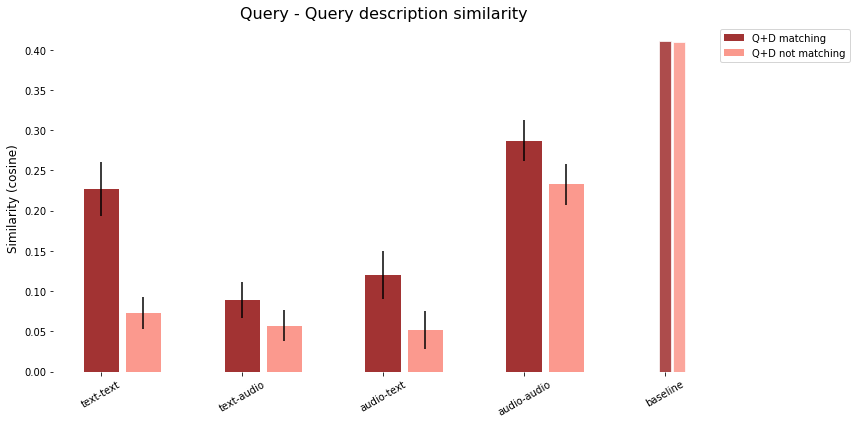

In [9]:
model_path_5m_mlp = '../logs/5m-mlp_2022-07-21_07-57-47'
results_5m_mlp = get_cosine_results(model_path_5m_mlp)
plot_results_baseline(results_5m_mlp, base_pos, base_neg, 'Query - Query description similarity', 'sim_results_5m_mlp.pdf')



### Plot results for  25M models

[MMloader] init from directory  ../../data/yamnet/processed/ train
[MMloader] train dataset loaded, length:  4301835
[MMloader] init from directory  ../../data/yamnet/processed/ val
[MMloader] val dataset loaded, length:  252398
[MMloader] init from directory  ../../data/yamnet/processed/ test
[MMloader] test dataset loaded, length:  1530873
Query natural encoded!
Descr natural encoded!


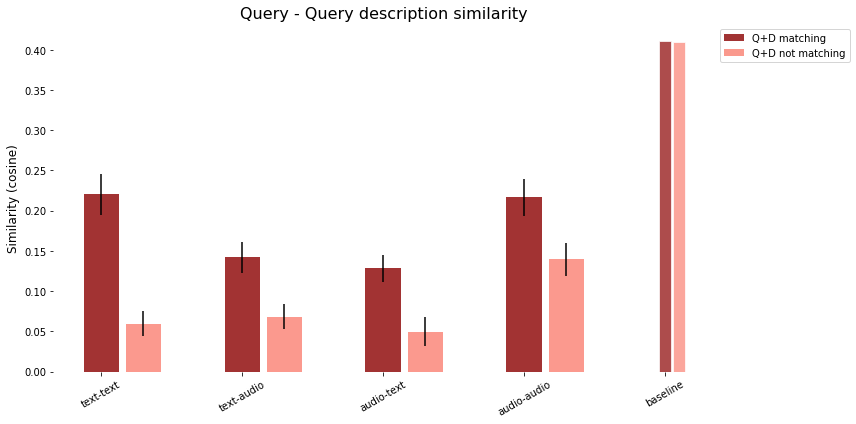

[MMloader] init from directory  ../../data/yamnet/processed/ train
[MMloader] train dataset loaded, length:  4301835
[MMloader] init from directory  ../../data/yamnet/processed/ val
[MMloader] val dataset loaded, length:  252398
[MMloader] init from directory  ../../data/yamnet/processed/ test
[MMloader] test dataset loaded, length:  1530873


/Users/casper/Documents/UvAmaster/b23456_thesis/msc_thesis/src/notebooks/../evaluate_topic.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  yamnets_mean = [torch.tensor(y.mean(dim=0).clone().detach()) for y in yamnets]


Query natural encoded!
Descr natural encoded!


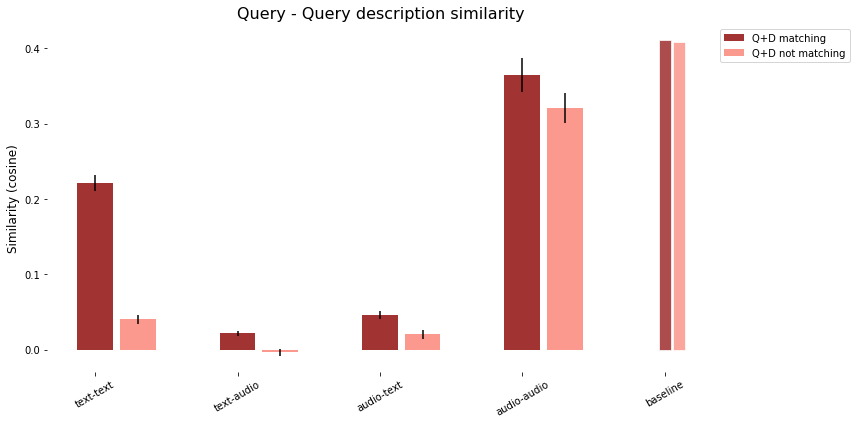

[MMloader] init from directory  ../../data/yamnet/processed/ train
[MMloader] train dataset loaded, length:  4301835
[MMloader] init from directory  ../../data/yamnet/processed/ val
[MMloader] val dataset loaded, length:  252398
[MMloader] init from directory  ../../data/yamnet/processed/ test
[MMloader] test dataset loaded, length:  1530873
Query natural encoded!
Descr natural encoded!


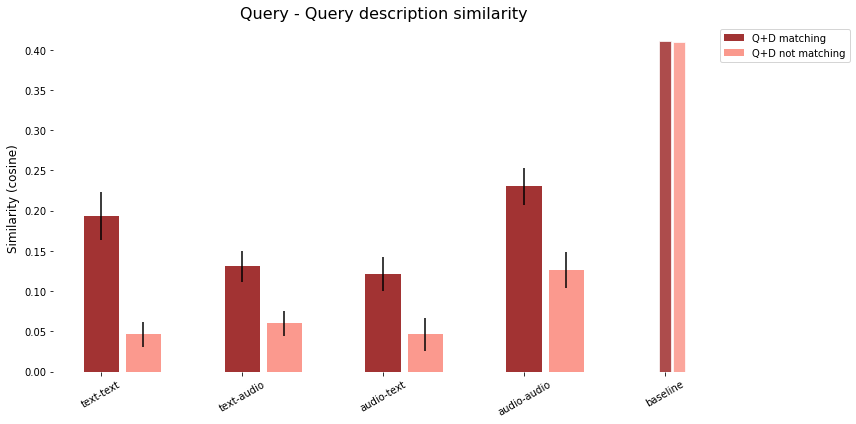

In [14]:
model_paths = ['../logs/25m-gru_2022-07-06_07-25-51',
              '../logs/25m-sph_2022-07-16_19-44-36',
              '../logs/25m-mlp_2022-07-05_10-54-42']
model_names = ['gru_25m', 'sph_25m', 'mlp_25m']


for model_name, model_path in zip(model_names, model_paths):  
    results = get_cosine_results(model_path)
    plot_results_baseline(results, base_pos,base_neg,'Query - Query description similarity', 'natural_{}.pdf'.format(model_name))